In [64]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler 
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
import missingno as msno
from sklearn.utils import shuffle 
#from category_encoders import TargetEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
sns.set(rc = {'figure.figsize': (20, 20)})
%matplotlib inline 

In [46]:
df = pd.read_json("cars_data.json")
df = df.dropna()
df.head(5)

,Prix,year,origin,firstCirculationDate,firstHand,mileage,energy,gearbox,externalColor,doors,ratedHorsePower,powerDIN,critAir,co2,marqueModele,owners
1,22770,2017,France,23/07/2017,Non,45 410 km,Essence,Manuelle,noir,3.0,11 CV,(DIN) 208 ch,1,125 g/km,PEUGEOT 208 GTI,2.0
2,15100,2018,France,11/04/2018,Non,131 044 km,Diesel,Manuelle,orange metal,5.0,5 CV,(DIN) 110 ch,2,98 g/km,RENAULT CAPTUR,3.0
3,26710,2018,France,14/04/2018,Non,88 811 km,Essence,Manuelle,gris metal,5.0,7 CV,(DIN) 131 ch,1,124 g/km,PEUGEOT 5008 II,2.0
5,16780,2019,France,01/03/2019,Non,78 498 km,Essence,Manuelle,noir,3.0,5 CV,(DIN) 110 ch,1,100 g/km,DS 3 phase 2,2.0
10,215120,2020,Importé,11/02/2020,Non,30 750 km,Essence,Automatique,ivoire verni,2.0,34 CV,(DIN) 450 ch,1,207 g/km,PORSCHE 911 TYPE 992,2.0


In [47]:
df.columns

Index(['Prix', 'year', 'origin', 'firstCirculationDate', 'firstHand',
       'mileage', 'energy', 'gearbox', 'externalColor', 'doors',
       'ratedHorsePower', 'powerDIN', 'critAir', 'co2', 'marqueModele',
       'owners'],
      dtype='object')

In [48]:
# Check for missing values
print(df.isnull().sum())

Prix                    0
year                    0
origin                  0
firstCirculationDate    0
firstHand               0
mileage                 0
energy                  0
gearbox                 0
externalColor           0
doors                   0
ratedHorsePower         0
powerDIN                0
critAir                 0
co2                     0
marqueModele            0
owners                  0
dtype: int64


In [49]:
#check for duplicates rows
print(df.duplicated().sum())

1


In [50]:
# Summary statistics for numerical columns
print(df.describe())

                Prix         year       doors      owners
count     529.000000   529.000000  529.000000  529.000000
mean    38040.283554  2018.714556    4.516068    2.249527
std     38432.524141     3.401175    0.965419    0.995313
min      7680.000000  2001.000000    2.000000    1.000000
25%     19020.000000  2017.000000    5.000000    2.000000
50%     26710.000000  2019.000000    5.000000    2.000000
75%     40230.000000  2021.000000    5.000000    3.000000
max    448950.000000  2024.000000    5.000000    7.000000


In [51]:
# Pre-processing
df['Prix'] = df['Prix'].astype(int)
df['year'] = df['year'].astype(int)
df['origin'] = df['origin'].replace({'Importé': 1, 'France': 0})
df['firstHand'] = df['firstHand'].replace({'Oui': 1, 'Non': 0})
df['mileage'] = df['mileage'].str.extract('(\d+)').astype(int) 
df['gearbox'] = df['gearbox'].replace({'Automatique': 1, 'Manuelle': 0})
df['ratedHorsePower'] = df['ratedHorsePower'].str.extract('(\d+)').astype(int)
df['powerDIN'] = df['powerDIN'].str.extract('(\d+)').astype(int)
df['doors'] = df['doors'].astype(int)
#df['marqueModele'] = df['marqueModele'].astype(str)
df['co2'] = df['co2'].str.extract('(\d+)').astype(int) 
df['critAir'] = df['critAir'].str.extract('(\d+)').astype(int) 
df['energy'] = df['energy'].replace({'Diesel' : 0,'Essence' : 1,'Hybride essence électrique' : 2,'Electrique' : 3,'Bicarburation essence bioéthanol' : 4,'Hybride diesel électrique' : 5, 'Bicarburation essence GPL' : 6})
df = df.drop(["firstCirculationDate", "externalColor", "marqueModele"], axis=1)

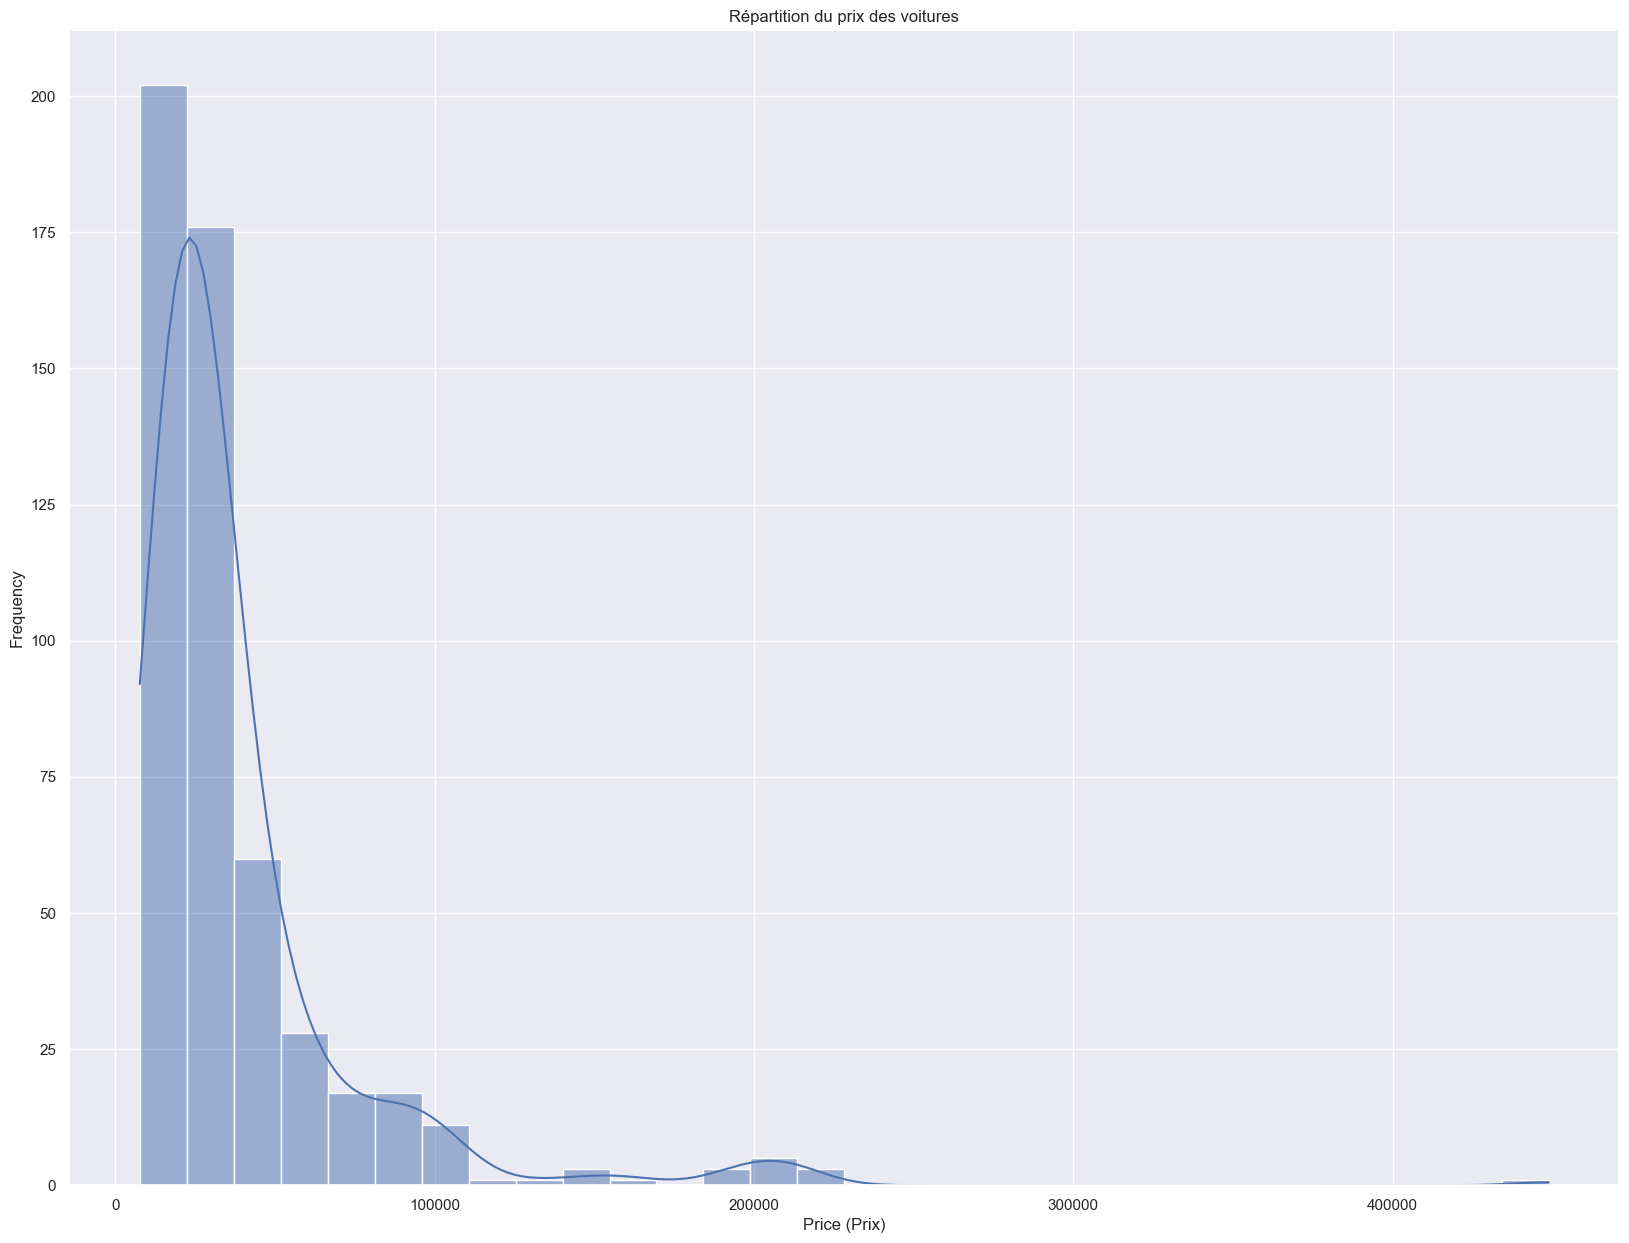

In [52]:
# Visualize the distribution of 'Prix' (price)
plt.figure(figsize=(20, 15))
sns.histplot(df['Prix'], bins=30, kde=True)
plt.xlabel('Price (Prix)')
plt.ylabel('Frequency')
plt.title('Répartition du prix des voitures')
plt.show()

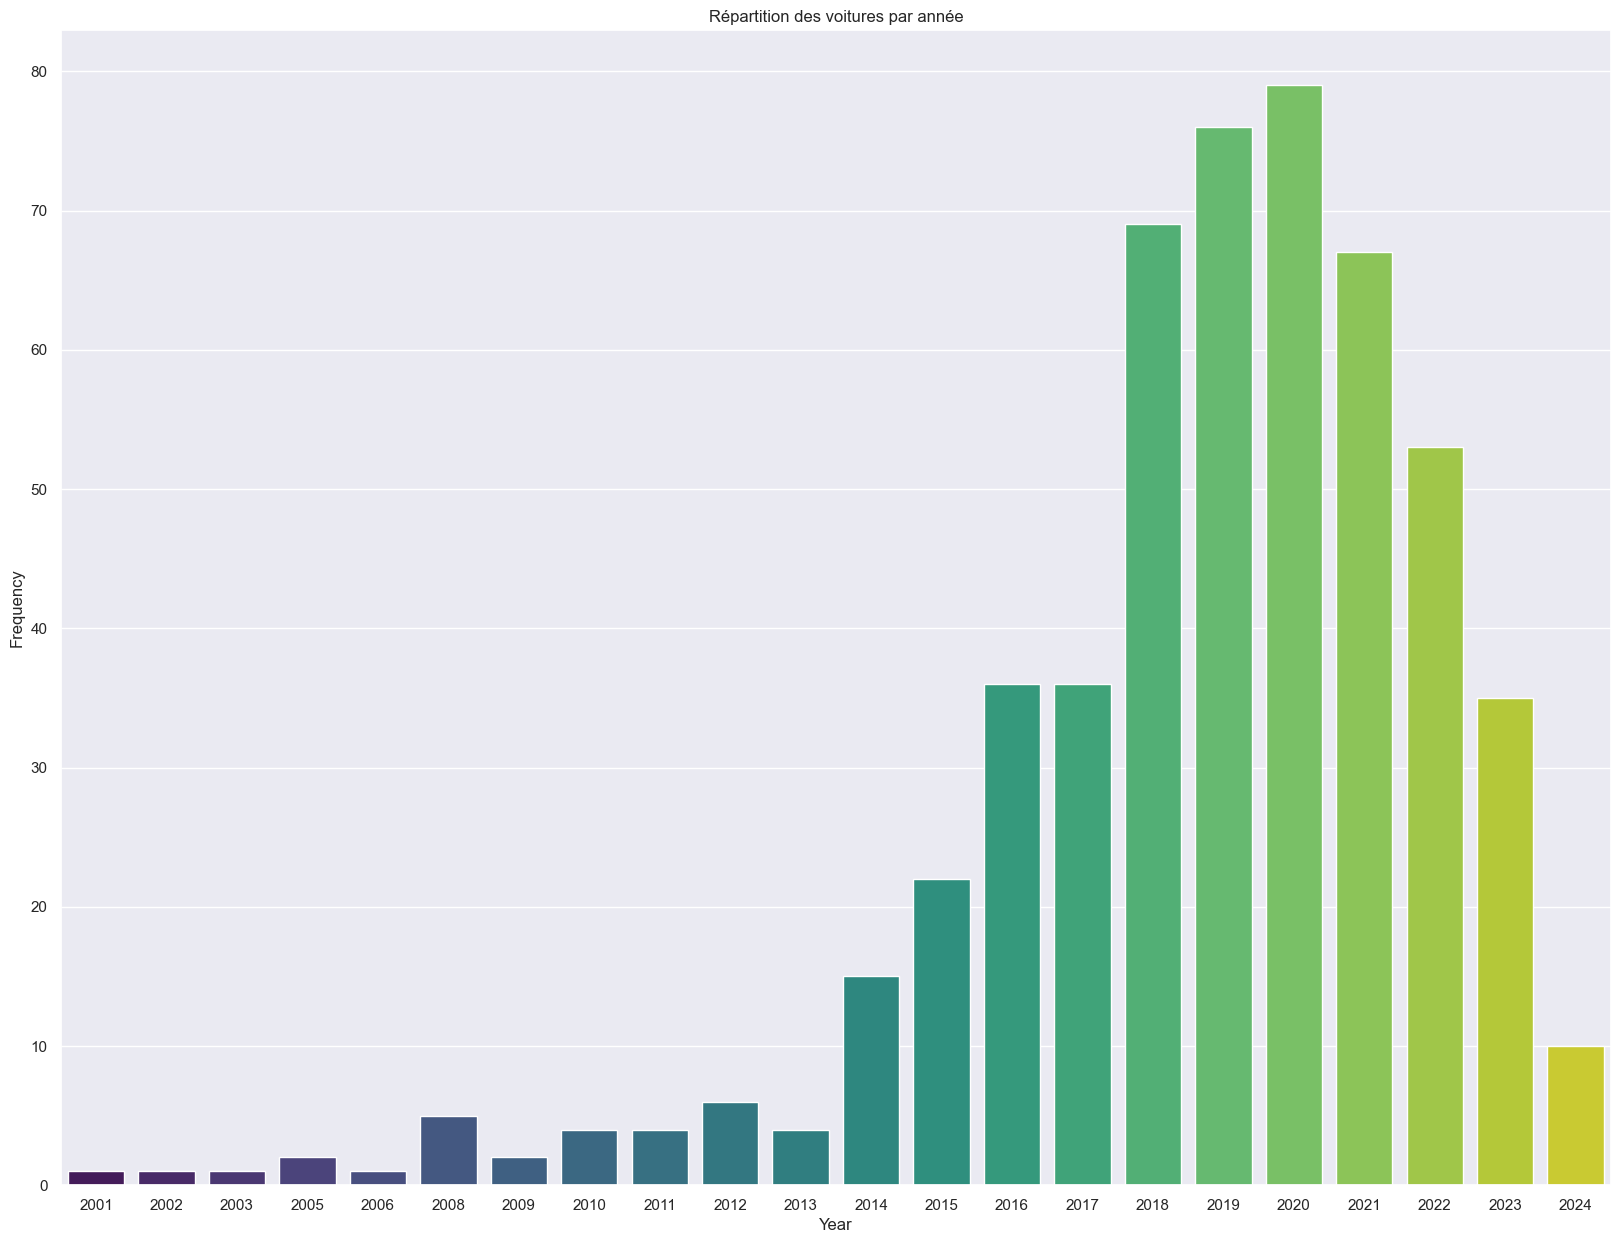

In [53]:
# Visualize the distribution of 'year'
plt.figure(figsize=(20, 15))
sns.countplot(x = df.year, palette = 'viridis')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Répartition des voitures par année')
plt.show()

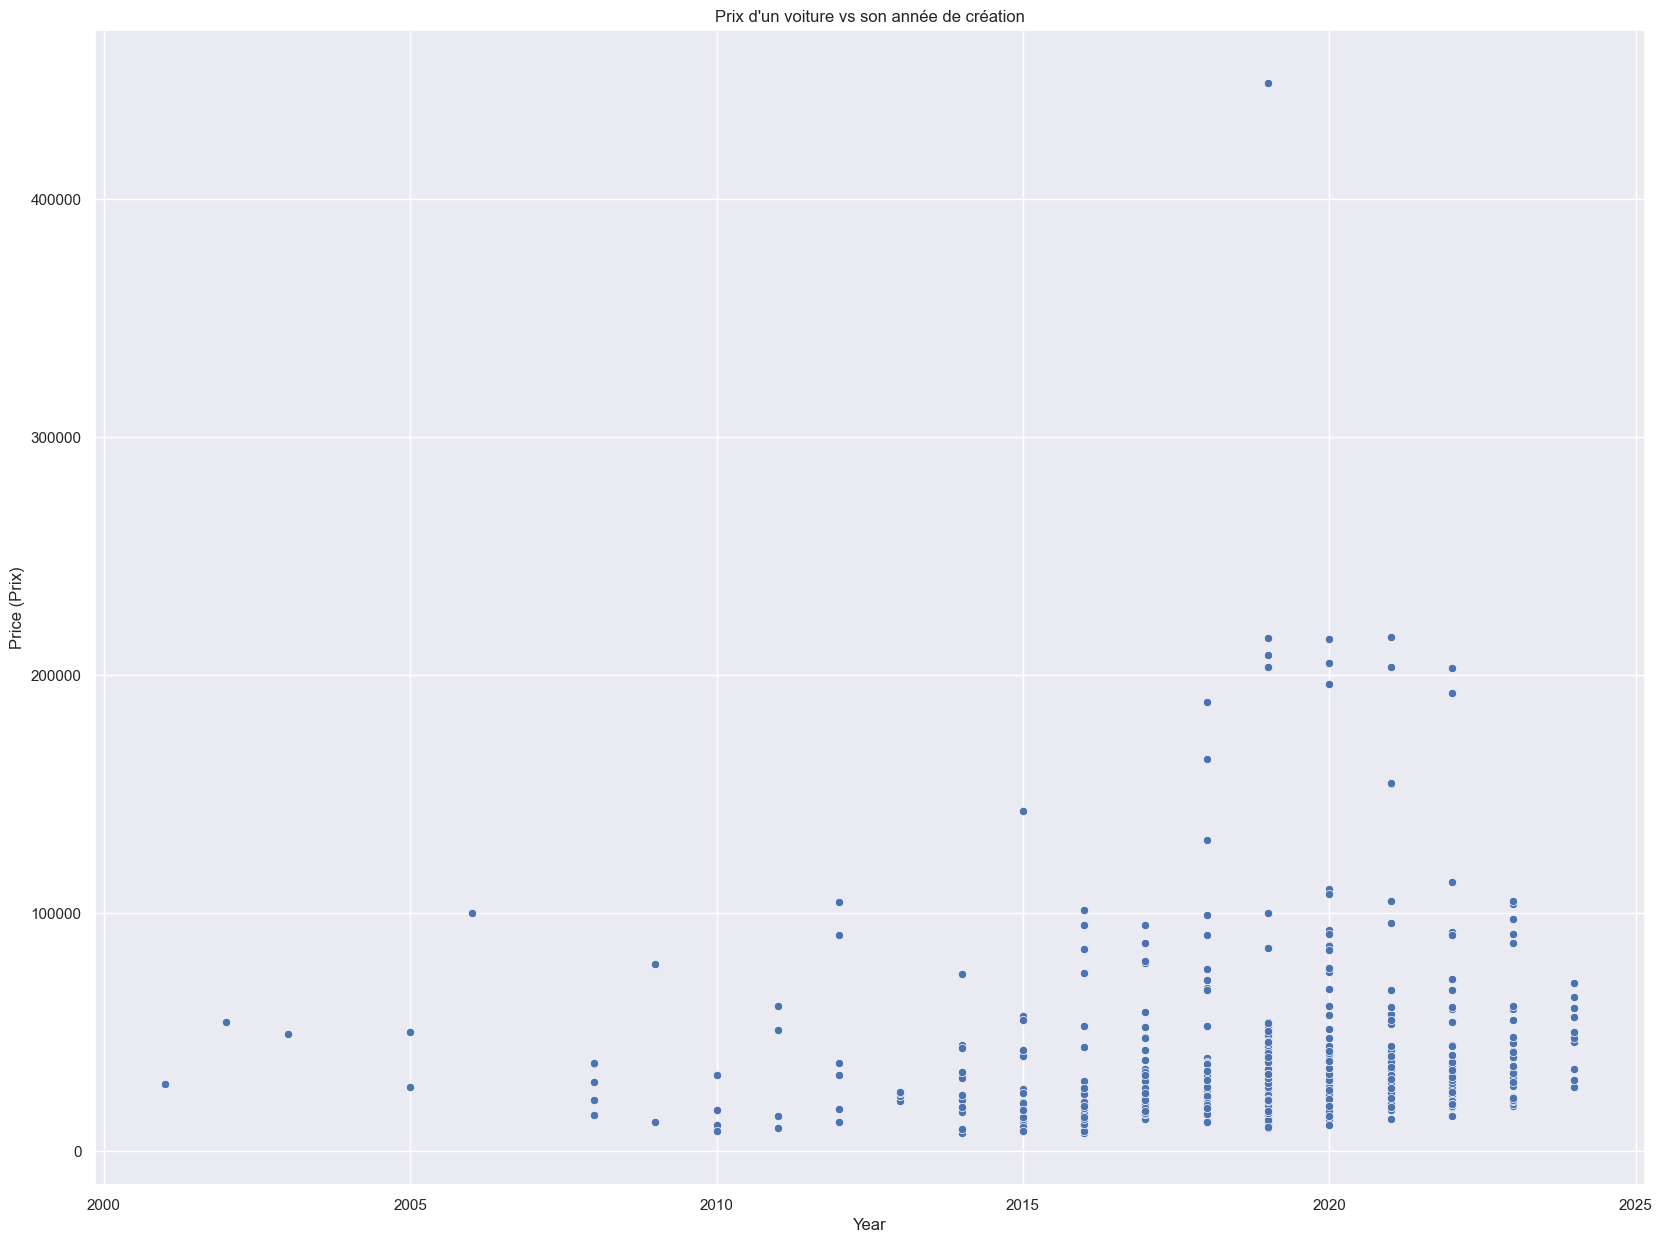

In [54]:
# Visualize the relationship between 'Prix' and 'year'
plt.figure(figsize=(20, 15))
sns.scatterplot(data=df, x='year', y='Prix')
plt.xlabel('Year')
plt.ylabel('Price (Prix)')
plt.title('Prix d\'un voiture vs son année de création')
plt.show()

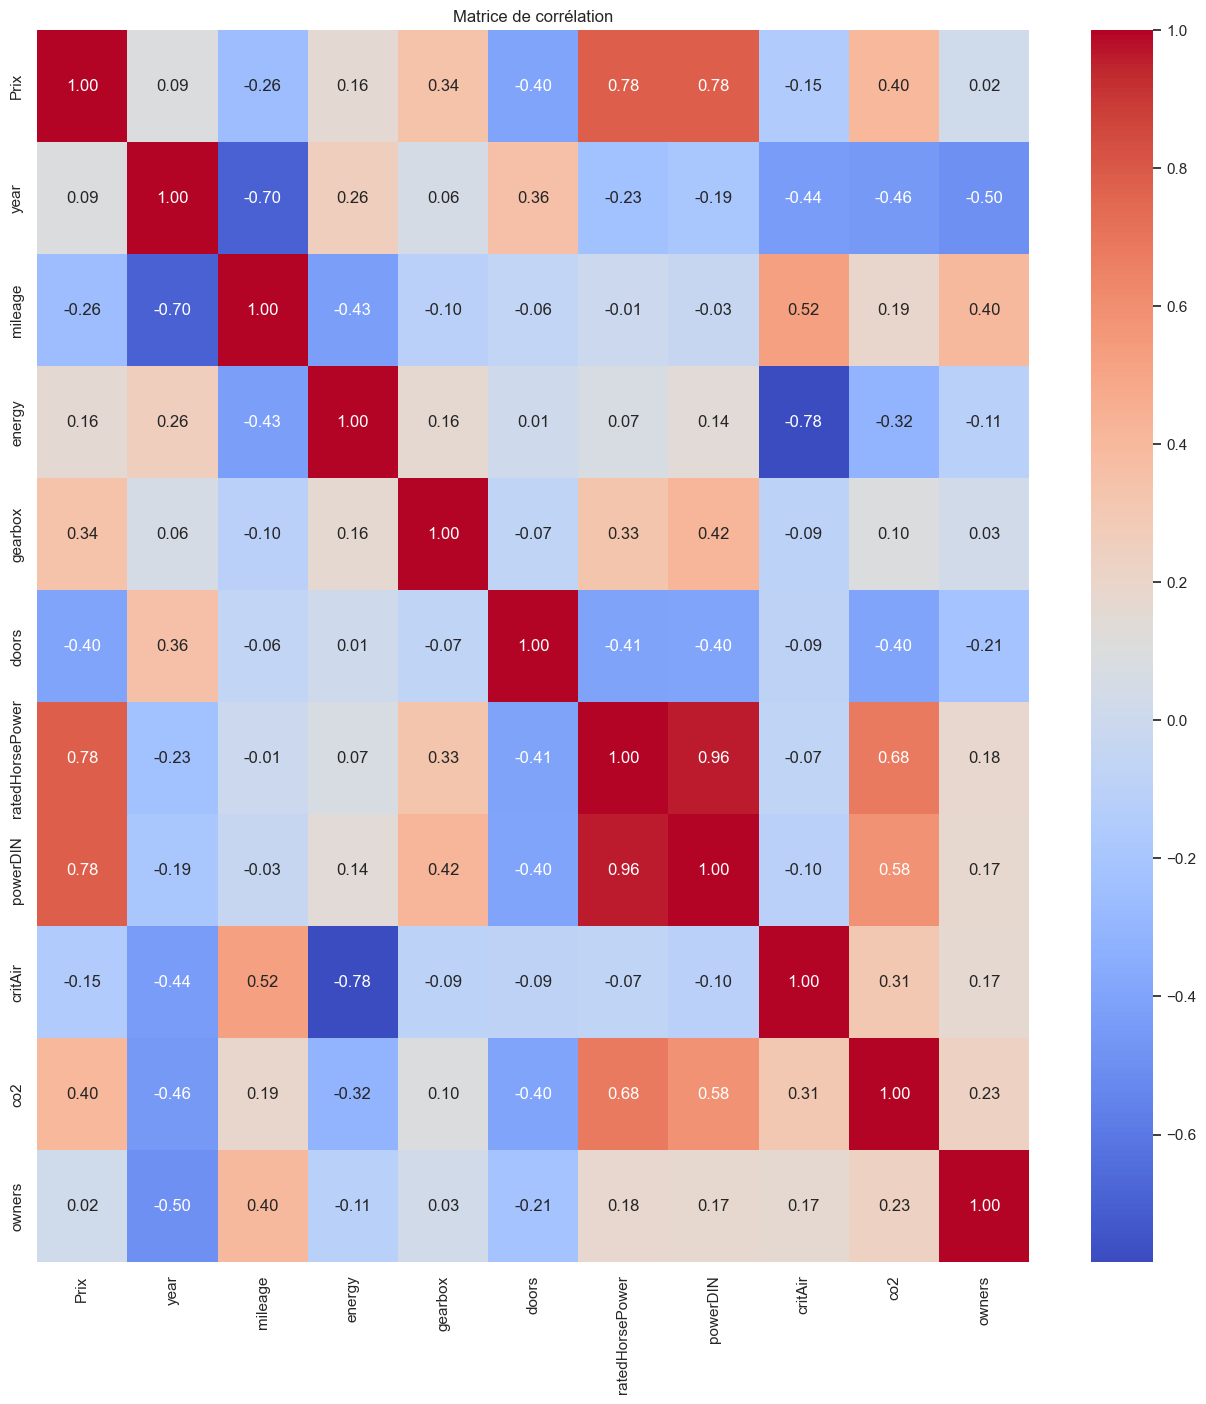

In [55]:
# Correlation
numeric_columns = ["Prix", "year", "mileage", "energy", "gearbox", "doors", "ratedHorsePower", "powerDIN", "critAir", "co2", "owners"]
heatmap_data = df[numeric_columns].corr()
plt.figure(figsize=(16, 16))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de corrélation')
plt.show()

In [56]:
X = df.drop(['Prix'], axis = 1)
y = df['Prix']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [57]:
(X_train.shape), (X_test.shape)

((423, 12), (106, 12))

In [58]:
(y_train.shape), (y_test.shape)

((423,), (106,))

In [59]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_new = scaler.transform(X_train)
X_test_new = scaler.transform(X_test)

In [60]:
X_train_new.shape

(423, 12)

# Régression Linéaire

In [61]:
model = LinearRegression()
model.fit(X_train_new, y_train)

LinearRegression()

In [ ]:
y_predict = model.predict(X_test_new)
y_predict = pd.DataFrame(y_predict, columns = ['Prédiction'])

In [ ]:
y_predict.head()

In [ ]:
y_test.to_frame().head()

In [ ]:
results = pd.concat([y_predict, y_test.to_frame().reset_index(drop = True)], axis = 1, ignore_index = False)
results.head()

In [ ]:
# Stockage des erreurs des différents algo de prédictions
error_mean_square = []
error_mean_absolute = []
error_mean_square.append(int(mean_squared_error(y_predict, y_test)))
error_mean_absolute.append(int(mean_absolute_error(y_predict, y_test)))

In [ ]:
plt.figure(figsize = (10, 10))
sns.regplot(data = results, y = 'Prédiction', x = 'Prix', color = 'teal', marker = 'o')
plt.title("Regression linéaire", fontsize = 20)
plt.show()

## Random Forest Regressor

In [62]:
# Define the features (X) and target (y)
target = 'Prix'
features = df.drop(columns=[target]).columns

X = df[features]
y = df[target]

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
# Model Training
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error: 7047.748113207546
Mean Squared Error: 145956942.3304717
R-squared: 0.8055648274190923


In [66]:
# Perform Min-Max scaling on the numerical features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

In [67]:
X = df[features]
y = df[target]

# Split the data into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [68]:
#  Feature Scaling (Normalize the data)
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Create and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_normalized, y_train)

# 5. Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_normalized)

# 6. Calculate the metrics (MAE and R2 score)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Model MAE:", mae_rf)
print("Random Forest Model R-squared:", r2_rf)

Random Forest Model MAE: 7097.9009433962265
Random Forest Model R-squared: 0.8030696274369457


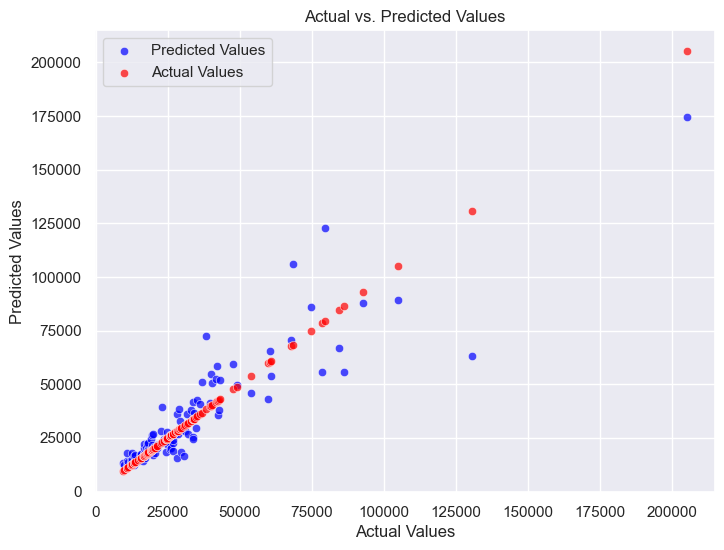

In [69]:
# Sort the actual and predicted values for the line plot
sorted_indices = np.argsort(y_test)
sorted_actual = y_test.iloc[sorted_indices]
sorted_predicted = y_pred_rf[sorted_indices]

# Ensure both arrays have the same length
min_len = min(len(sorted_actual), len(sorted_predicted))
sorted_actual = sorted_actual[:min_len]
sorted_predicted = sorted_predicted[:min_len]

# Create a DataFrame for the scatter plot
data = pd.DataFrame({
    'Actual Values': sorted_actual,
    'Predicted Values': sorted_predicted
})

# Plot the actual versus predicted values using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Actual Values', y='Predicted Values', data=data, color='blue', alpha=0.7)
sns.scatterplot(x=sorted_actual, y=sorted_actual, color='red', alpha=0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend(labels=['Predicted Values', 'Actual Values'], loc='upper left')
plt.show()

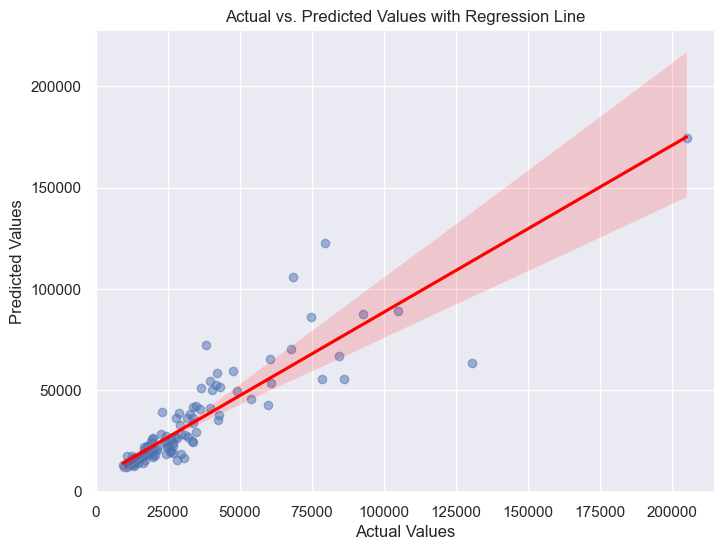

In [70]:
# Plot the regression line along with the actual and predicted values
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred_rf, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values with Regression Line")
plt.show()